In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import xmltodict
import requests
import json

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read dataset
g_df = pd.read_csv('../dataset/AWS_gwangsan.csv',encoding='cp949')
g_df = g_df[:-1]
g_df['일시'] = pd.to_datetime(g_df['일시'])

In [3]:
# Make dates dataframe
dates = pd.date_range('20240101','20250101',freq='T',inclusive='neither').to_list()#.strftime('%Y-%m-%d %H:%M').to_list()
df = pd.DataFrame(columns=['일시'])
df['일시'] = dates

In [4]:
len(dates)

527039

In [5]:
# Merge dataframe ([dates, AWS])
g_data = pd.merge(df,g_df,on='일시',how='outer')
g_data = g_data[['일시','1분 강수량(mm)', '강수유무(유무)']]
g_data.rename(columns={'일시':'dates','1분 강수량(mm)':'rn','강수유무(유무)':'flag'},inplace=True)

In [6]:
# Read levels data
levels = pd.read_csv('../dataset/smart_rain/gwangjoo/processed_gwangjoo_2920010001045020.csv')
levels.rename(columns={'crtr_tm':'dates'}, inplace=True)

In [7]:
# Merge dataframe ([dates, AWS, levels])
g_data['dates'] = g_data['dates'].astype('str')
g_levels = pd.merge(g_data,levels,on='dates',how='outer')

In [8]:
# Make 10min dates list
start = '2024-01-01 00:10'
end = '2024-12-31 23:59'

all_dates = pd.date_range(start=start, end=end, freq='10T')#.strftime('%Y%m%d%H%M').to_list()

monthly_lists = []

for month in range(1, 13):
    monthly_dates = all_dates[all_dates.month == month]
    monthly_dates = monthly_dates.strftime('%Y%m%d%H%M')
    monthly_lists.append(list(monthly_dates))

In [9]:
apiKey = 'B9344389-836E-43B7-9AF5-A2400B1A3065'
code = '5002690' #광주광역시(장록교)
start_dt = '202401010000'
end_dt = '202412312350'
wl_df = pd.DataFrame(columns=['ymdhm','wlobscd','wl','fw'])

# Request water level data
for m in monthly_lists:
    url = f'http://api.hrfco.go.kr/{apiKey}/waterlevel/list/10M/{code}/{m[0]}/{m[-1]}.xml'
    res = requests.get(url)
    xmlToDict = xmltodict.parse(res.text) # return collections.OrderedDict
    df_dict = json.loads(json.dumps(xmlToDict)) # return dict
    tmp_df= df_dict['entities']['content']['Waterlevel']
    tmp_df = pd.DataFrame(tmp_df)

    wl_df = pd.concat([wl_df,tmp_df])

In [10]:
# Sorting dataframe
wl_df.sort_values(by='ymdhm',inplace=True,ignore_index=True)
wl_df['ymdhm'] = pd.to_datetime(wl_df['ymdhm'])
wl_df['ymdhm'] = wl_df['ymdhm'].astype('str')
wl_df.rename(columns={'ymdhm':'dates'},inplace=True)

# 
wl_df = wl_df[['dates','wl']]

In [11]:
g_levels = pd.merge(g_levels,wl_df,on='dates',how='outer')

In [12]:
data = g_levels[86399:]
data.reset_index(inplace=True,drop=True)
data['rn'] = data['rn'].astype(float)
data['wl'] = data['wl'].astype(float)
data['vl'] = data['vl'].astype(float)

In [13]:
print(f'Rainfall min, max, mean : {data['rn'].min()}, {data['rn'].max()}, {np.round(data['rn'].mean(),5)}')
print(f'River level min, max, mean : {data['wl'].min()}, {data['wl'].max()}, {np.round(data['wl'].mean(),5)}')
print(f'Sewer level min, max, mean : {data['vl'].min()}, {data['vl'].max()}, {np.round(data['vl'].mean(),5)}')

Rainfall min, max, mean : 0.0, 3.0, 0.00287
River level min, max, mean : 1.41, 3.32, 1.72885
Sewer level min, max, mean : 0.0, 100.0, 16.07972


In [38]:
np.unique(data['vl'])

array([  0.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  72.,  73.,  74.,  76.,  77.,  78.,  80.,  81.,
        82.,  84.,  85.,  86.,  87.,  88.,  90.,  91.,  92.,  93.,  94.,
        95.,  96.,  97.,  98.,  99., 100.,  nan])

In [33]:
data['vl'] = data['vl'].interpolate()
data['wl'] = data['wl'].interpolate()

In [36]:
data.keys()

Index(['dates', 'rn', 'flag', 'vl', 'data_clct_se', 'wl'], dtype='object')

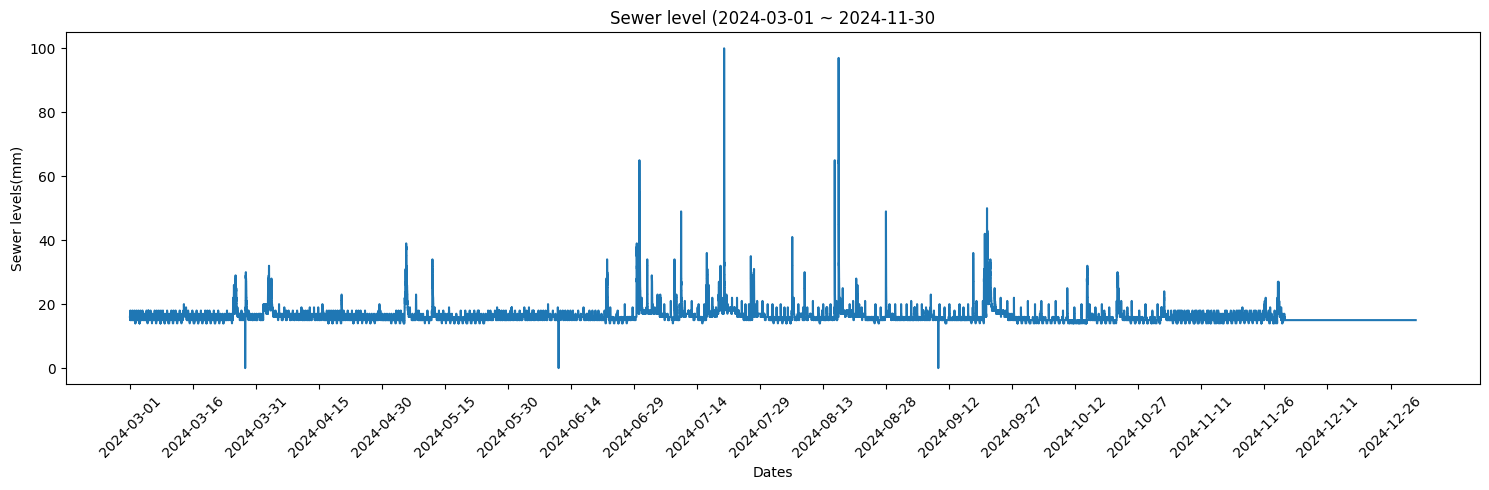

In [38]:
# x축 값을 리스트로 지정

time_str_list = data['dates'].to_list()
interval = 21600  # 15일 = 1440분 * 15

tick_positions = list(range(0, len(time_str_list), interval))
tick_labels = [time_str_list[i][:10] for i in tick_positions]  # 'YYYY-MM-DD' 형식만 추출

# 예시 y값 (동일 길이)
y_values = list(range(len(time_str_list)))

# 그래프 그리기
plt.figure(figsize=(15, 5))
plt.plot(time_str_list, data['vl'])

# x축 라벨 적용 (보름마다만)
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)

plt.title('Sewer level (2024-03-01 ~ 2024-11-30)')
plt.xlabel('Dates')
plt.ylabel('Sewer levels(mm)')

plt.tight_layout()
plt.show()

In [339]:
data['vl'] = data['vl'].replace(0,np.nan)

In [345]:
data['vl'] = data['vl'].interpolate()

In [267]:
g_levels['vl'].max()

100.0